In [9]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
from scipy.interpolate import interp2d
import os
import sys
from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate
import h5py
from auxiliary_merge import m_DateList


def dist2coast_cal(filedist2coast, xynew):
    d = np.load(filedist2coast)
    latdist = d['latdist']
    londist = d['londist']
    dist2coast = d['dist2coast']
    xynew[xynew[:, 0] < np.min(latdist), 0] = np.min(latdist)
    xynew[xynew[:, 0] > np.max(latdist), 0] = np.max(latdist)
    xynew[xynew[:, 1] < np.min(londist), 1] = np.min(londist)
    xynew[xynew[:, 1] > np.max(londist), 1] = np.max(londist)

    latdist = np.flipud(latdist)  # ascending latitude
    dist2coast = np.flipud(dist2coast)
    rg = RegularGridInterpolator((latdist, londist), dist2coast, method='linear')
    distnew = rg(xynew)
    return distnew


def demread(file, lattar, lontar):
    datatemp = io.loadmat(file)
    demori = datatemp['DEM']
    ratio = datatemp['pixelratio']
    demori[ratio < 0.5] = 0  # ocean pixels
    demori[np.isnan(demori)] = 0
    info = datatemp['Info'][0][0]
    latori = np.arange(info['yll'] + info['Ysize'] * info['nrows'] - info['Ysize'] / 2, info['yll'], -info['Ysize'])
    lonori = np.arange(info['xll'] + info['Xsize'] / 2, info['xll'] + info['Xsize'] * info['ncols'], info['Xsize'])
    f = interp2d(lonori, latori, demori, kind='linear')
    demtar = f(lontar.flatten(), lattar.flatten())
    demtar = np.flipud(demtar)
    return demtar


def neargrid(rowtar, coltar, rowori, colori, hwsize):
    # inputs are 1D matrices
    # tar is target area
    # ori is original area
    # hwsize is half window size (e.g., 4 means the space window width/length is 2*4+1)
    # find a space window centering the target grid in the original area and calculate the weights
    nrows = len(rowtar)
    ncols = len(coltar)
    rowse = np.zeros([nrows, ncols, 2]).astype(int)  # se: start/end
    colse = np.zeros([nrows, ncols, 2]).astype(int)  # se: start/end
    weight = np.nan * np.zeros([nrows, ncols, (hwsize * 2 + 1) ** 2])  # from left to right/from top to bottom weight

    for rr in range(nrows):
        rowloc = np.argmin(np.abs(rowori - rowtar[rr]))
        rowse[rr, :, 0] = rowloc - hwsize
        rowse[rr, :, 1] = rowloc + hwsize

    for cc in range(ncols):
        colloc = np.argmin(np.abs(colori - coltar[cc]))
        colse[:, cc, 0] = colloc - hwsize
        colse[:, cc, 1] = colloc + hwsize

    rowse[rowse < 0] = 0
    rowse[rowse > nrows] = nrows
    colse[colse < 0] = 0
    colse[colse > ncols] = nrows

    maxdist = (hwsize + 0.5) * np.sqrt(2) + 0.5
    for rr in range(nrows):
        rowloc = np.argmin(np.abs(rowori - rowtar[rr]))
        for cc in range(ncols):
            colloc = np.argmin(np.abs(colori - coltar[cc]))

            rowse_rc = rowse[rr, cc, :]
            colse_rc = colse[rr, cc, :]
            flag = 0
            for i in range(rowse_rc[0], rowse_rc[1] + 1):
                for j in range(colse_rc[0], colse_rc[1] + 1):
                    dist = ((rowloc - i) ** 2 + (colloc - j) ** 2) ** 0.5
                    weight[rr, cc, flag] = au.distanceweight(dist, maxdist, 3)
                    flag = flag + 1

            weight[rr, cc, :] = weight[rr, cc, :] / np.nansum(weight[rr, cc, :])

    return rowse, colse, weight


def readownscale_grid_GWR(dataori, latori, lonori, demori, dist2coast_ori, lattar, lontar, demtar, dist2coast_tar,
                          rowse, colse, weight, mask):
    nrows = len(lattar)
    ncols = len(lontar)
    ntimes = np.shape(dataori)[2]
    lonori, latori = np.meshgrid(lonori, latori)
    datatar = np.nan * np.zeros([nrows, ncols, ntimes])

    for rr in range(nrows):
        print('row',rr,nrows)
        for cc in range(ncols):
            if mask[rr, cc] == 1:
                rloc = rowse[rr, cc, :]
                cloc = colse[rr, cc, :]
                midr = int((rloc[0] + rloc[1]) / 2)
                midc = int((cloc[0] + cloc[1]) / 2)

                latnear = latori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                lonnear = lonori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                demnear = demori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
                distnear = dist2coast_ori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]

                nnum = np.size(latnear)
                latnear = np.reshape(latnear, nnum)
                lonnear = np.reshape(lonnear, nnum)
                demnear = np.reshape(demnear, nnum)
                distnear = np.reshape(distnear, nnum)
                weightnear = np.zeros([nnum, nnum])
                for i in range(nnum):
                    weightnear[i, i] = weight[rr, cc, i]

                if demori[midr, midc] == 0:
                    induse = demnear == 0  # if the station is within a land grid, exclude ocean grids from nearby grids
                else:
                    induse = demnear != 0  # if the station is within a ocean grid, exclude land grids from nearby grids

                if np.sum(induse) < 10:
                    # few nearby grids can be used for regression, thus will just use nearest neighbor
                    datatar[rr, cc, :] = dataori[midr, midc, :]
                    continue

                nearinfo = np.zeros([nnum, 5])
                nearinfo[:, 0] = 1
                nearinfo[:, 1] = latnear
                nearinfo[:, 2] = lonnear
                nearinfo[:, 3] = demnear
                nearinfo[:, 4] = distnear
                nearinfo = nearinfo[induse, :]
                weightnear = weightnear[induse, :]
                weightnear = weightnear[:, induse]

                tarinfo = np.zeros(5)
                tarinfo[0] = 1
                tarinfo[1] = lattar[rr]
                tarinfo[2] = lontar[cc]
                tarinfo[3] = demtar[rr, cc]
                tarinfo[4] = dist2coast_tar[rr, cc]

                tx_red = np.transpose(nearinfo)
                twx_red = np.matmul(tx_red, weightnear)

                for tt in range(ntimes):
                    datanear = dataori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1, tt]
                    datanear = np.reshape(datanear, nnum)
                    datanear = datanear[induse]

                    # upper and lower boundary for the downscaled data
                    # this is a conservative limitation
                    lowbound = np.min(datanear)
                    upbound = np.max(datanear)
                    if np.sign(lowbound) == 1:
                        lowbound = lowbound * 0.8
                    else:
                        lowbound = lowbound * 1.2
                    if np.sign(upbound) == 1:
                        upbound = upbound * 1.2
                    else:
                        upbound = upbound * 0.8

                    b = reg.least_squares(nearinfo, datanear, twx_red)
                    datatemp = np.dot(tarinfo, b)
                    if np.all(b == 0) or datatemp > upbound or datatemp < lowbound or np.isnan(datatemp):
                        datatar[rr, cc, tt] = dataori[midr, midc, tt]
                    else:
                        datatar[rr, cc, tt] = datatemp
    return datatar


def readownscale_tostn(dataori, latori, lonori, demori, dist2coast_ori, rowse, colse, weight, stn_row, stn_col,
                       data0, method, stn_lle, dist2coast_stn, tlr):
    nstn = len(stn_row)
    ntimes = np.shape(dataori)[2]
    datatar = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)

    if method == 'linear' or method == 'nearest':
        xynew = stn_lle[:, [0, 1]]
        latori = np.flipud(latori)  # ascending latitude
        dataori = np.flipud(dataori)
        for i in range(ntimes):
            # print('Time step:',i,ntimes)
            rg = RegularGridInterpolator((latori, lonori), dataori[:, :, i], method=method)
            datatar[:, i] = rg(xynew)

    elif method == 'GWR':
        lonori, latori = np.meshgrid(lonori, latori)
        for gg in range(nstn):
            if np.mod(gg, 5000) == 0:
                print('station', gg, nstn)

            if np.isnan(data0[gg]):
                continue  # station does not have observations, thus does not need downscaling

            rr = stn_row[gg]
            cc = stn_col[gg]
            rloc = rowse[rr, cc, :]
            cloc = colse[rr, cc, :]
            midr = int((rloc[0] + rloc[1]) / 2)
            midc = int((cloc[0] + cloc[1]) / 2)
            latnear = latori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
            lonnear = lonori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
            demnear = demori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]
            distnear = dist2coast_ori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1]

            nnum = np.size(latnear)
            latnear = np.reshape(latnear, nnum)
            lonnear = np.reshape(lonnear, nnum)
            demnear = np.reshape(demnear, nnum)
            distnear = np.reshape(distnear, nnum)
            weightnear = np.zeros([nnum, nnum])
            for i in range(nnum):
                weightnear[i, i] = weight[rr, cc, i]

            if demori[midr, midc] == 0:
                induse = demnear == 0  # if the station is within a land grid, exclude ocean grids from nearby grids
            else:
                induse = demnear != 0  # if the station is within a ocean grid, exclude land grids from nearby grids

            if np.sum(induse) < 10:
                # few nearby grids can be used for regression, thus will just use nearest neighbor
                datatar[gg, :] = dataori[midr, midc, :]
                continue

            nearinfo = np.zeros([nnum, 5])
            nearinfo[:, 0] = 1
            nearinfo[:, 1] = latnear
            nearinfo[:, 2] = lonnear
            nearinfo[:, 3] = demnear
            nearinfo[:, 4] = distnear
            nearinfo = nearinfo[induse, :]
            weightnear = weightnear[induse, :]
            weightnear = weightnear[:, induse]

            tarinfo = np.zeros(5)
            tarinfo[0] = 1
            tarinfo[1] = stn_lle[gg, 0]
            tarinfo[2] = stn_lle[gg, 1]
            tarinfo[3] = stn_lle[gg, 2]
            tarinfo[4] = dist2coast_stn[gg]

            tx_red = np.transpose(nearinfo)
            twx_red = np.matmul(tx_red, weightnear)

            for tt in range(ntimes):
                datanear = dataori[rloc[0]:rloc[1] + 1, cloc[0]:cloc[1] + 1, tt]
                datanear = np.reshape(datanear, nnum)
                datanear = datanear[induse]

                # upper and lower boundary for the downscaled data
                # this is a conservative limitation
                lowbound = np.min(datanear)
                upbound = np.max(datanear)
                if np.sign(lowbound) == 1:
                    lowbound = lowbound * 0.8
                else:
                    lowbound = lowbound * 1.2
                if np.sign(upbound) == 1:
                    upbound = upbound * 1.2
                else:
                    upbound = upbound * 0.8

                b = reg.least_squares(nearinfo, datanear, twx_red)
                datatemp = np.dot(tarinfo, b)
                if np.all(b == 0) or datatemp > upbound or datatemp < lowbound or np.isnan(datatemp):
                    datatar[gg, tt] = dataori[midr, midc, tt]
                else:
                    datatar[gg, tt] = datatemp

    elif method == 'TLR1' or method == 'TLR2':
        # downscale original data to sea level
        demori2 = demori[:, :, np.newaxis] / 1000
        demori2 = np.tile(demori2, [1, 1, ntimes])
        dataori = dataori - demori2 * tlr

        # linearly interpolated dataori to stations
        xynew = stn_lle[:, [0, 1]]
        latori = np.flipud(latori)  # ascending latitude
        dataori = np.flipud(dataori)
        for i in range(ntimes):
            # print('Time step:',i,ntimes)
            rg = RegularGridInterpolator((latori, lonori), dataori[:, :, i], method='linear')
            datatar[:, i] = rg(xynew)

        # recover from sea level to actual elevation
        for i in range(nstn):
            rowi = np.argmin(abs(stn_lle[i, 0] - latori))
            coli = np.argmin(abs(stn_lle[i, 1] - lonori))
            tlri = tlr[rowi, coli, :]
            datatar[i, :] = datatar[i, :] + stn_lle[i, 2] / 1000 * tlri
    else:
        sys.exit('Unknown downscaling method')
    return datatar


def readstndata(inpath_raw, stnID, ndays):
    nstn = len(stnID)
    prcp_stn = np.nan * np.zeros([nstn, ndays], dtype=np.float32)
    tmin_stn = np.nan * np.zeros([nstn, ndays], dtype=np.float32)
    tmax_stn = np.nan * np.zeros([nstn, ndays], dtype=np.float32)

    for i in range(nstn):
        if np.mod(i, 1000) == 0:
            print('station', i, nstn)
        file = inpath_raw + '/' + stnID[i] + '.nc'
        fid = nc.Dataset(file)
        varlist = fid.variables.keys()
        if 'prcp' in varlist:
            prcp_stn[i, :] = fid['prcp'][:].data
        if 'tmin' in varlist:
            tmin_stn[i, :] = fid['tmin'][:].data
        if 'tmax' in varlist:
            tmax_stn[i, :] = fid['tmax'][:].data
        fid.close()

    tmean_stn = (tmin_stn + tmax_stn) / 2
    trange_stn = np.abs(tmax_stn - tmin_stn)

    return prcp_stn, tmean_stn, trange_stn


########################################################################################################################

# time periods and methods
# method choices: "GWR", "nearest", "linear", "TLR1", "TLR2". Note: TLR1 is fixed tlr of -6.5. TLR2 is MERRA2-based tlr.


# read from inputs
# a = int(sys.argv[1])
# b = int(sys.argv[2])
# downtostn_method = sys.argv[3]
# year = [a, b]

# fixed
year = [2018, 2018]
downtostn_method = 'GWR'
print('start/end year', year)
print('downtostn_method', downtostn_method)

########################################################################################################################

# basic information: to be set before running
vars = ['prcp', 'tmin', 'tmax']
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
hwsize = 2  # use (2*2+1)**2 grids to perform regression

### Local Mac settings
# input files/paths
filedem = './DEM/NA_DEM_010deg_trim.mat' # DEM for the target region(0.1 degree)
filedem_era = './DEM/MERRA2_DEM2.mat' # DEM for the original reanalysis
filedist2coast = '/Users/localuser/Research/EMDNA/dist2coast_001.npz' # 0.01-degree distance to coast
filetlr = '/Users/localuser/Research/EMDNA/MERRA2_TLR.mat' # temperature lapse rate from MERRA2
gmet_stnfile = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt' # station lists
gmet_stnpath = '/Users/localuser/GMET/StnInput_daily' # station files for gmet_stnfile

# output files/paths (can also be used as inputs once generated)
filenear = '/Users/localuser/Research/EMDNA/downscale/MERRA2/MERRA2_weight_dem.npz' # file of dem and near gird information
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_whole.npz' # to be saved. only process when absent
inpath_raw = '/Users/localuser/Research/EMDNA/downscale/MERRA2' # path for original gridded reanalysis data
outpath_ds = '/Users/localuser/Research/EMDNA/downscale/MERRA2' # path for saving downscaled reanalysis data
### Local Mac settings

# ### Plato settings
# # input files/paths
# filedem = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'  # DEM for the target region(0.1 degree)
# filedem_era = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/DEM/MERRA2_DEM2.mat'  # DEM for the original reanalysis
# filedist2coast = '/datastore/GLOBALWATER/CommonData/EMDNA/Auxiliary/dist2coast_001.npz'  # 0.01-degree distance to coast
# filetlr = '/datastore/GLOBALWATER/CommonData/EMDNA/Auxiliary/EMDNA/MERRA2_TLR.mat'  # temperature lapse rate from MERRA2
# gmet_stnfile = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'  # station lists
# gmet_stnpath = '/home/gut428/GMET/StnInput_daily'  # station files for gmet_stnfile
#
# # output files/paths (can also be used as inputs once generated)
# filenear = '/home/gut428/MERRA2_day_ds/MERRA2_weight_dem.npz'  # file of dem and near gird information
# gmet_stndatafile = '/datastore/GLOBALWATER/CommonData/EMDNA/stndata_whole.npz'  # to be saved. only process when absent
# inpath_raw = '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_raw'  # path for original gridded reanalysis data
# outpath_ds = '/home/gut428/MERRA2_day_ds'  # path for saving downscaled reanalysis data
# ### Plato settings

# output downscale file at station points
file_readownstn = outpath_ds + '/MERRA2_downto_stn_' + downtostn_method + '.npz'  # downscale to station points (1979-2018)

start/end year [2018, 2018]
downtostn_method GWR


In [2]:
########################################################################################################################

# prepare basic infomation

# 1. date lists from 1979 to 2018 (this corresponds to station data). this should be changed in future
date_list, date_number = m_DateList(1979, 2018, 'ByYear')
ndays = len(date_number['yyyymmdd'])  # days from 1979 to 2018

# 2. basic lat/lon/elev information
# read DEM/mask
datatemp = io.loadmat(filedem)
demtar = datatemp['DEM']  # this is consistent with lontar lattar
mask = demtar.copy()
mask[~np.isnan(mask)] = 1

# station lat/lon/elev and their row/col in the target DEM/mask
stn_ID = np.genfromtxt(gmet_stnfile, dtype='str', skip_header=1, comments='#', delimiter=',', usecols=(0), unpack=False)
stn_lle = np.loadtxt(gmet_stnfile, dtype=float, skiprows=1, comments='#', delimiter=',', usecols=(1, 2, 3),
                     unpack=False)
stn_row = ((85 - stn_lle[:, 0]) / 0.1).astype(int)
stn_col = ((stn_lle[:, 1] + 180) / 0.1).astype(int)
nstn = len(stn_ID)

# load the lat/lon of original data
infile = inpath_raw + '/MERRA2_' + vars[0] + '_' + str(year[1]) + '.mat'
datatemp = {}
f = h5py.File(infile, 'r')
for k, v in f.items():
    datatemp[k] = np.array(v)
latori = datatemp['latitude'][0]
lonori = datatemp['longitude'][0]
del datatemp

# 3. load temperature lapse rate (TLR) to support "TLR" downscaling. 12 climatological monthly maps.
dt = io.loadmat(filetlr)
TLRori = dt['TLRori']
latM0 = dt['latM0']
lonM0 = dt['lonM0']
del dt

TLRnew = np.nan * np.zeros([len(latori), len(lonori), np.shape(TLRori)[2]])
for i in range(np.shape(TLRori)[2]):
    f = interpolate.interp2d(latM0, lonM0, TLRori[:, :, 0], kind='linear')
    tlrnew = f(latori, lonori)
    tlrnew = np.flipud(tlrnew.T)
    TLRnew[:, :, i] = tlrnew
TLRuse = np.nan * np.zeros([len(latori), len(lonori), 12])
for i in range(12):
    TLRuse[:, :, i] = np.nanmean(TLRnew[:, :, np.arange(i, np.shape(TLRori)[2], 12)], axis=2)

del TLRori, TLRnew

# 4. calculate distance to coast from a 0.01 degree map using linear interpolation
dist2coast_stn = dist2coast_cal(filedist2coast, stn_lle[:, [0, 1]])

lonorim, latorim = np.meshgrid(lonori, latori)
xynew = np.vstack((latorim.flatten(), lonorim.flatten())).T
dist2coast_ori = dist2coast_cal(filedist2coast, xynew)
dist2coast_ori = np.reshape(dist2coast_ori, np.shape(latorim))

lontarm, lattarm = np.meshgrid(lontar, lattar)
xynew = np.vstack((lattarm.flatten(), lontarm.flatten())).T
dist2coast_tar = dist2coast_cal(filedist2coast, xynew)
dist2coast_tar = np.reshape(dist2coast_tar, np.shape(lattarm))

In [7]:
# read all station data and save to facilitate analysis in the future
if not os.path.isfile(gmet_stndatafile):
    prcp_stn, tmean_stn, trange_stn = readstndata(gmet_stnpath, stn_ID, ndays)
    np.savez_compressed(gmet_stndatafile, prcp_stn=prcp_stn, tmean_stn=tmean_stn, trange_stn=trange_stn,
                        stn_ID=stn_ID, stn_lle=stn_lle, stn_row=stn_row, stn_col=stn_col)

########################################################################################################################

# for 0.1 degree grids, calculate its near grid (raw reanalysis resolutino)
if not os.path.isfile(filenear):
    rowse, colse, weight = neargrid(lattar, lontar, latori, lonori, hwsize)
    # extract ori dem
    demori = demread(filedem_era, latori, lonori)
    io.savemat(filenear, {'rowse': rowse, 'colse': colse, 'weight': weight, 'demori': demori})
else:
    datatemp = io.loadmat(filenear)
    rowse = datatemp['rowse']
    colse = datatemp['colse']
    weight = datatemp['weight']
    demori = datatemp['demori']
    del datatemp

In [10]:
# downscale reanalysis to 0.1 degree
for y in range(year[0], year[1] + 1):
    for v in range(len(vars)):
        print('year--var:', y, vars[v])
        infile = inpath_raw + '/MERRA2_' + vars[v] + '_' + str(y) + '.mat'
        outfile_grid = outpath_ds + '/MERRA2_ds_' + vars[v] + '_' + str(y) + '.npz'
        if os.path.isfile(outfile_grid):
            continue

        # load original daily reanalysis data
        datatemp = {}
        f = h5py.File(infile, 'r')
        for k, v in f.items():
            datatemp[k] = np.array(v)
        dataori = datatemp['data']
        dataori = np.transpose(dataori, [2, 1, 0])
        del datatemp
        f.close()

        # downscale the reanalysis to 0.1 degree
        datatar = readownscale_grid_GWR(dataori, latori, lonori, demori, dist2coast_ori,
                                        lattar, lontar, demtar, dist2coast_tar, rowse, colse, weight, mask)
        datatar = np.float32(datatar)
        np.savez_compressed(outfile_grid, data=datatar, latitude=lattar, longitude=lontar)

    # tmin/tmax to tmean/trange
    infile1 = outpath_ds + '/MERRA2_ds_tmin_' + str(y) + '.npz'
    infile2 = outpath_ds + '/MERRA2_ds_tmax_' + str(y) + '.npz'
    outfile1 = outpath_ds + '/MERRA2_ds_tmean_' + str(y) + '.npz'
    outfile2 = outpath_ds + '/MERRA2_ds_trange_' + str(y) + '.npz'
    if os.path.isfile(outfile1) and os.path.isfile(outfile2):
        continue
    tmin = np.load(infile1)
    tmin = tmin['data']
    tmax = np.load(infile2)
    tmax=tmax['data']
    tmean = (tmin+tmax)/2
    trange = np.abs(tmax-tmin)
    np.savez_compressed(outfile1, data=np.float32(tmean), latitude=lattar, longitude=lontar)
    np.savez_compressed(outfile2, data=np.float32(trange), latitude=lattar, longitude=lontar)

year--var: 2018 prcp
row 0 800
row 1 800
row 2 800
row 3 800
row 4 800
row 5 800
row 6 800
row 7 800
row 8 800
row 9 800
row 10 800
row 11 800
row 12 800
row 13 800
row 14 800
row 15 800
row 16 800
row 17 800
row 18 800
row 19 800
row 20 800
row 21 800
row 22 800
row 23 800


KeyboardInterrupt: 

In [18]:
file='/Users/localuser/Downloads/MERRA2_ds_prcp_2018.npz'
d=np.load(file)
data=d['data']

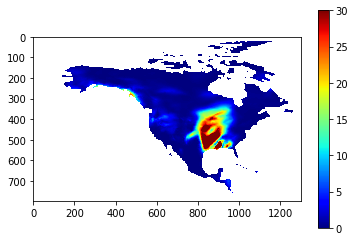

In [30]:
plt.imshow(data[:,:,360],cmap='jet')
plt.clim([0,30])
plt.colorbar()

In [21]:
import h5py
file='/Users/localuser/Research/EMDNA/downscale/MERRA2/MERRA2_prcp_2018.mat'
datatemp = {}
f = h5py.File(file, 'r')
for k, v in f.items():
    datatemp[k] = np.array(v)
dataori = datatemp['data']
dataori = np.transpose(dataori, [2, 1, 0])

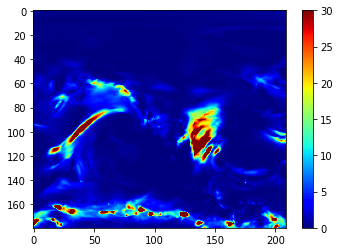

In [31]:
temp=dataori[:,:,360]
plt.imshow(temp,cmap='jet')
plt.clim([0,30])
plt.colorbar()